In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
from torch.utils.data import DataLoader

In [2]:
#device setup
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [3]:
# New

import torch
import torchvision
from torchvision import transforms
# Set up random seed for consistency
torch.manual_seed(1)

# Hyperparameters based on slides
lr = 2e-4
batch_sz = 128
img_size = 64
# Grayscale: 1 for color images: 3 (R, G, B)
img_channels = 3
noise_dim = 100
num_epochs = 25
discriminator_feat = 64
generator_feat = 64
adam_beta1 = 0.5

# Get CIFAR-10 dataset
num_workers = 2
transformations = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(img_channels)], [0.5 for _ in range(img_channels)]
        ),
    ]
)

cifar_train = torchvision.datasets.CIFAR10(root='./data',
                                           train=True,
                                           transform=transformations,
                                           download=True)

training_loader = torch.utils.data.DataLoader(cifar_train, batch_size=batch_sz,
                                             shuffle=True, num_workers=num_workers)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [3]:
#set up seed for consistancy
torch.manual_seed(1)
#hyperparameters based on slides
learning_rate = 2e-4
batch_size = 128
image_size = 64
#black and white 1 for color img 3(r.g.b)
image_channels = 3
noise_dimension = 100
epochs = 25
discriminator_features = 64
generator_features = 64
adam_beta = 0.5
#get Cifar10 dataset
workers = 2
transforms = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(image_channels)], [0.5 for _ in range(image_channels)]
        ),
    ]
)
data_train = torchvision.datasets.CIFAR10(root='./data', 
                                           train=True, 
                                           transform=transforms,  
                                           download=True)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                          shuffle=True,num_workers=workers)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


In [66]:
class DiscriminatorNet(nn.Module):
    def __init__(self, img_channels, feat_discriminator):
        super(DiscriminatorNet, self).__init__()
        self.disc_net = nn.Sequential(
            nn.Conv2d(
                img_channels, feat_discriminator, kernel_size=4, stride=2, padding=1
            ),
            nn.LeakyReLU(0.2),
            self._disc_block(feat_discriminator, feat_discriminator * 2, 4, 2, 1),
            self._disc_block(feat_discriminator * 2, feat_discriminator * 4, 4, 2, 1),
            self._disc_block(feat_discriminator * 4, feat_discriminator * 8, 4, 2, 1),
            nn.Conv2d(feat_discriminator * 8, 1, kernel_size=4, stride=2, padding=0),
            nn.Sigmoid(),
        )

    def _disc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.LeakyReLU(0.2),
        )

    def forward(self, x):
        return self.disc_net(x)


class GeneratorNet(nn.Module):
    def __init__(self, noise_channels, img_channels, feat_generator):
        super(GeneratorNet, self).__init__()
        self.gen_net = nn.Sequential(
            self._gen_block(noise_channels, feat_generator * 16, 4, 1, 0),  # img: 4x4
            self._gen_block(feat_generator * 16, feat_generator * 8, 4, 2, 1),  # img: 8x8
            self._gen_block(feat_generator * 8, feat_generator * 4, 4, 2, 1),  # img: 16x16
            self._gen_block(feat_generator * 4, feat_generator * 2, 4, 2, 1),  # img: 32x32
            nn.ConvTranspose2d(
                feat_generator * 2, img_channels, kernel_size=4, stride=2, padding=1
            ),
            nn.Tanh(),
        )

    def _gen_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size,
                stride,
                padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def forward(self, x):
        return self.gen_net(x)


In [5]:
def model_weights(model):
    # Initializes weights according to the DCGAN paper
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d, nn.BatchNorm2d)):
            nn.init.normal_(m.weight.data, 0.0, 0.02)

In [67]:
gen_net = GeneratorNet(noise_dim, img_channels, generator_feat).to(device)
disc_net = DiscriminatorNet(img_channels, discriminator_feat).to(device)
model_weights(gen_net)
model_weights(disc_net)

opt_gen = optim.Adam(gen_net.parameters(), lr=lr, betas=(adam_beta1, 0.999))
opt_disc = optim.Adam(disc_net.parameters(), lr=lr, betas=(adam_beta1, 0.999))
criterion = nn.BCELoss()

fixed_noise = torch.randn(10, noise_dim, 1, 1).to(device)
step = 0
loss_ge = []
loss_de = []
gen_net.train()
disc_net.train()
fakeimg_list = []
img_list = []

accuracies = []

for epoch in range(num_epochs):
    correct = 0
    total = 0
    for batch_idx, (real, _) in enumerate(training_loader):
        real = real.to(device)
        noise = torch.randn(batch_sz, noise_dim, 1, 1).to(device)
        fake = gen_net(noise)

        disc_real = disc_net(real).reshape(-1)
        loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
        disc_fake = disc_net(fake.detach()).reshape(-1)
        loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
        loss_disc = (loss_disc_real + loss_disc_fake) / 2
        disc_net.zero_grad()
        loss_de.append(loss_disc.detach().cpu())
        loss_disc.backward()
        opt_disc.step()

        output = disc_net(fake).reshape(-1)
        loss_gen = criterion(output, torch.ones_like(output))
        loss_ge.append(loss_gen.detach().cpu())
        gen_net.zero_grad()
        loss_gen.backward()
        opt_gen.step()

        with torch.no_grad():
            real = real.to(device)
            noise = torch.randn(batch_sz, noise_dim, 1, 1).to(device)
            fake = gen_net(noise)
            disc_real = disc_net(real).reshape(-1)
            disc_fake = disc_net(fake.detach()).reshape(-1)
            preds = torch.cat((disc_real, disc_fake), 0)
            targets = torch.cat(
                (torch.ones_like(disc_real), torch.zeros_like(disc_fake)), 0
            )
            correct += (preds.round() == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total
    accuracies.append(accuracy)
    print(f"Epoch [{epoch}/{num_epochs}] Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}, Accuracy: {accuracy:.4f}")

    fak = gen_net(fixed_noise).detach().cpu()
    realI = real.detach().cpu()
    fakeimg_list.append(torchvision.utils.make_grid(fak, padding=2, normalize=True))
    img_list.append(torchvision.utils.make_grid(realI, padding=2, normalize=True))


Epoch [0/25] Loss D: 0.2146, loss G: 2.2405, Accuracy: 0.9356
Epoch [1/25] Loss D: 0.4847, loss G: 1.5043, Accuracy: 0.8321
Epoch [2/25] Loss D: 0.5971, loss G: 1.3015, Accuracy: 0.7207
Epoch [3/25] Loss D: 0.6625, loss G: 1.0089, Accuracy: 0.6992
Epoch [4/25] Loss D: 0.6798, loss G: 1.1054, Accuracy: 0.7112
Epoch [5/25] Loss D: 0.5556, loss G: 1.3593, Accuracy: 0.6908
Epoch [6/25] Loss D: 0.5187, loss G: 1.2442, Accuracy: 0.6969
Epoch [7/25] Loss D: 0.4331, loss G: 1.6596, Accuracy: 0.7158
Epoch [8/25] Loss D: 0.6503, loss G: 0.9638, Accuracy: 0.6944
Epoch [9/25] Loss D: 0.6373, loss G: 1.0927, Accuracy: 0.6710
Epoch [10/25] Loss D: 0.6465, loss G: 0.8692, Accuracy: 0.6338
Epoch [11/25] Loss D: 0.6762, loss G: 0.9776, Accuracy: 0.6277
Epoch [12/25] Loss D: 0.6299, loss G: 0.8487, Accuracy: 0.6644
Epoch [13/25] Loss D: 0.6431, loss G: 1.6207, Accuracy: 0.6655
Epoch [14/25] Loss D: 0.5771, loss G: 1.0689, Accuracy: 0.6458
Epoch [15/25] Loss D: 0.6572, loss G: 0.8011, Accuracy: 0.6676
Ep

In [61]:
gen_net.train(), disc_net.train()

(GeneratorNet(
   (gen_net): Sequential(
     (0): Sequential(
       (0): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (1): Sequential(
       (0): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (2): Sequential(
       (0): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
     (3): Sequential(
       (0): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (2): ReLU()
     )
    

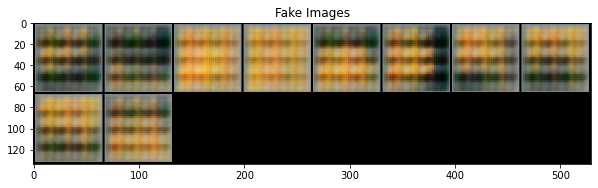

In [68]:
def show_images_for_epoch(epoch_number):
    if 0 <= epoch_number < len(img_list):
        plt.figure(figsize=(10, 10))
        # plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(fakeimg_list[epoch_number], (1, 2, 0)))
        plt.title("Fake Images")
        # plt.subplot(1, 2, 2)
        # plt.imshow(np.transpose(img_list[epoch_number], (1, 2, 0)))
        # plt.title("Real Images")
        plt.show()
    else:
        print("Invalid epoch number.")
# To visualize the images for a specific epoch
epoch_to_visualize = 0  # Change this value to visualize images for a different epoch
show_images_for_epoch(epoch_to_visualize)

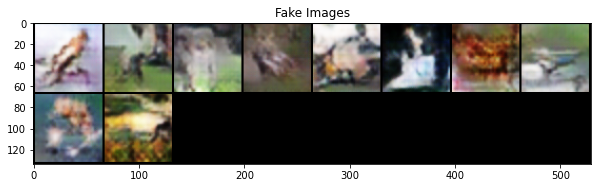

In [69]:
def show_images_for_epoch(epoch_number):
    if 0 <= epoch_number < len(img_list):
        plt.figure(figsize=(10, 10))
        # plt.subplot(1, 2, 1)
        plt.imshow(np.transpose(fakeimg_list[epoch_number], (1, 2, 0)))
        plt.title("Fake Images")
        # plt.subplot(1, 2, 2)
        # plt.imshow(np.transpose(img_list[epoch_number], (1, 2, 0)))
        # plt.title("Real Images")
        plt.show()
    else:
        print("Invalid epoch number.")
# To visualize the images for a specific epoch
epoch_to_visualize = 24  # Change this value to visualize images for a different epoch
show_images_for_epoch(epoch_to_visualize)

In [65]:
epoch_number

NameError: name 'epoch_number' is not defined

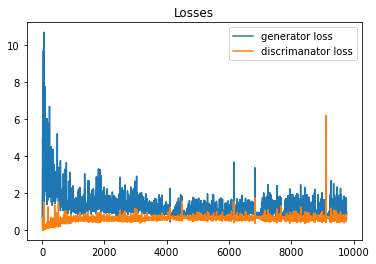

In [70]:
plt.title('Losses')
plt.plot(loss_ge,label = "generator loss")
plt.plot(loss_de,label = "discrimanator loss")
plt.legend()

In [54]:
# plt.title('Losses')
# plt.plot(accuracies,label = "Accuracy")

# plt.legend()

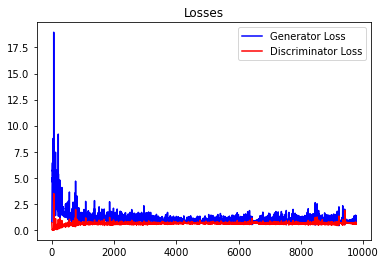

In [58]:
plt.title('Losses')
plt.plot(loss_ge, label="Generator Loss", color='blue')
plt.plot(loss_de, label="Discriminator Loss", color='red')
plt.legend()
plt.show()
